**This code will generate the heatmap image for FreeViewing Task**
- Input:
    - img filename
    - participant name
    - window size

- Output:
    - heatmap image with fixation points

Caution: Recover the coordinates before plotting the scanpath image.

*The code bellow will plot heatmap for one person*
- *Parameters should be adjusted if you want to plot for all participants*

Window size: 10 seconds
Window frames: 600


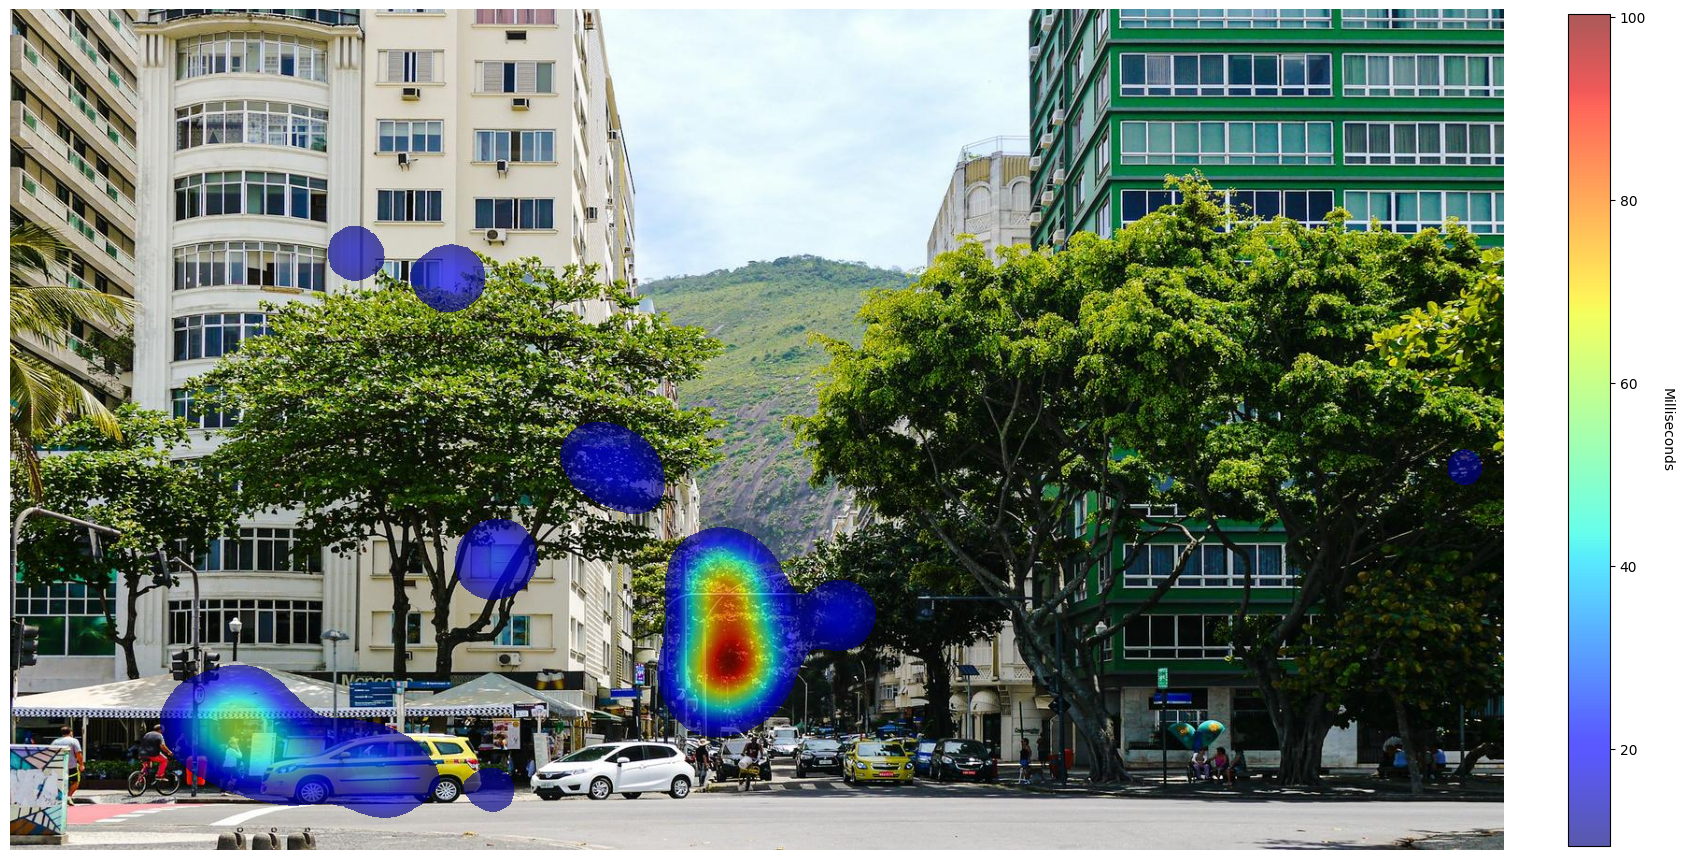

In [41]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import cv2

class GazeHeatmap:
    def __init__(self, participant, image_name, window_size, display_width=1600, display_height=900, alpha=0.6, n_gaussian_matrix=100, standard_deviation=30, gaussian_threshold=0.8):
        self.root_dir = '../../../'
        self.participant = participant
        self.image_name = image_name
        self.image_name_clean = image_name.split('.')[0]
        self.window_size = window_size # seconds
        self.window_frames = self.window_size * 60 # 60Hz
        
        self.image_path = os.path.join(self.root_dir, 'Data_Collection/FreeViewing/Training/', self.image_name)
        self.display_width = display_width
        self.display_height = display_height
        self.alpha = alpha
        self.n_gaussian_matrix = n_gaussian_matrix
        self.standard_deviation = standard_deviation
        self.gaussian_threshold = gaussian_threshold
        
        self.input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{self.participant}_IMG_1.csv')
        self.output_filedir = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Heatmap')
        if not os.path.exists(self.output_filedir):
            os.makedirs(self.output_filedir)
        self.output_filepath = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Heatmap', f'{self.participant}_{self.image_name_clean}_{self.window_size}sec.jpg')

    def draw_display(self):
        screen = np.zeros((self.display_height, self.display_width, 3), dtype='float32')
        if self.image_path is not None:
            if not os.path.isfile(self.image_path):
                raise Exception(f"ERROR in draw_display: imagefile not found at '{self.image_path}'")
            # Load image with matplotlib's image module
            img = image.imread(self.image_path)
            # Ensure the image is in the correct format
            if img.dtype == np.float32:
                # Normalize if the image is in float format (common for .png)
                img = np.clip(img, 0, 1)
            elif img.dtype == np.uint8:
                # Convert to float and normalize if the image is in byte format (common for .jpg)
                img = img.astype('float32') / 255

            # width and height of the image
            w, h = img.shape[1], img.shape[0]
            # x and y position of the image on the display
            x = self.display_width // 2 - w // 2
            y = self.display_height // 2 - h // 2
            # draw the image on the screen
            screen[y:y + h, x:x + w, :] += img[:,:,:3]  # Use only RGB channels
        dpi = 100.0
        figsize = (self.display_width / dpi, self.display_height / dpi)
        fig = plt.figure(figsize=figsize, dpi=dpi, frameon=False)
        ax = plt.Axes(fig, [0, 0, 1, 1])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.axis([0, self.display_width, 0, self.display_height])
        ax.imshow(screen)
        return fig, ax

    def gaussian(self, x, sx, y=None, sy=None):
        if y is None:
            y = x
        if sy is None:
            sy = sx
        xo = x // 2
        yo = y // 2
        M = np.zeros([y, x], dtype=float)
        for i in range(x):
            for j in range(y):
                M[j, i] = np.exp(-1.0 * (((float(i) - xo) ** 2 / (2 * sx ** 2)) + ((float(j) - yo) ** 2 / (2 * sy ** 2))))
        return M

    def draw_heatmap(self):
        fig, ax = self.draw_display()
        gwh = self.n_gaussian_matrix
        gsdwh = gwh // 6 if (self.standard_deviation is None) else self.standard_deviation
        gaus = self.gaussian(gwh, gsdwh)
        strt = gwh // 2
        heatmapsize = self.display_height + 2 * strt, self.display_width + 2 * strt
        heatmap = np.zeros(heatmapsize, dtype=float)
        for i in range(len(self.gaze_data)):
            x = strt + self.gaze_data[i][0] - gwh // 2
            y = strt + self.gaze_data[i][1] - gwh // 2
            if 0 > x or x > self.display_width or 0 > y or y > self.display_height:
                continue
            heatmap[y:y + gwh, x:x + gwh] += gaus * self.gaze_data[i][2]
        heatmap = heatmap[strt:self.display_height + strt, strt:self.display_width + strt]

        # Apply Gaussian blur to smooth the heatmap
        heatmap = cv2.GaussianBlur(heatmap, (21, 21), 0)

        lowbound = np.percentile(heatmap[heatmap > 0], int(self.gaussian_threshold*100))  # Adjust the percentile as needed
        heatmap[heatmap < lowbound] = np.NaN
        im = ax.imshow(heatmap, cmap='jet', alpha=self.alpha, vmin=lowbound, vmax=np.nanmax(heatmap))
        ax.invert_yaxis()

        # Add colorbar legend
        cbar = plt.colorbar(im, ax=ax, fraction=0.026, pad=0.04)
        cbar.set_label('Milliseconds', rotation=270, labelpad=20)
        
        if self.output_filepath is not None:
            fig.savefig(self.output_filepath)
        return fig

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6/5 * p[0] - 1/10, 6/5 * p[1] - 1/10)

    def to_pixel(self, coord):
        coord = eval(coord)
        if len(coord)!= 2 or coord[0] == None or coord[1] == None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)

    def run(self):
        df = pd.read_csv(self.input_filepath)
        # Create a condition to filter the DataFrame
        condition = df['stimuli'] == self.image_name_clean
        selected_data = df[condition].iloc[-self.window_frames:]
        
        print(f"Window size: {self.window_size} seconds")
        print(f"Window frames: {self.window_frames}")

        if selected_data.empty:
            raise ValueError(f"No data found for the given window size: {self.window_size} seconds")
        
        self.MW = selected_data['state'].iloc[0] == 'num_6'
        gaze_cor_name = "{}_gaze_point_on_display_area".format(df.loc[condition, 'eye_to_use'].iloc[0])
        
        selected_data['pixel_gaze_point'] = selected_data[gaze_cor_name].apply(self.to_pixel)
        gaze_data_list = selected_data['pixel_gaze_point'].tolist()
        # Filter out (None, None) entries
        filtered_gaze_data_list = [cor for cor in gaze_data_list if cor != (None, None)]
        self.gaze_data = [(int(cor[0]), int(cor[1]), 1) for cor in filtered_gaze_data_list]
        self.draw_heatmap()


if __name__ == '__main__':
    participant = '1Y'
    image_name = 'Brazil_1.jpg'
    window_size = 10 # seconds
    
    n_gaussian_matrix = 150
    standard_deviation = 30
    alpha = 0.65
    gaussian_threshold = 0.8
    
    heatmap = GazeHeatmap(participant, image_name, window_size, n_gaussian_matrix=n_gaussian_matrix, standard_deviation=standard_deviation, alpha=alpha, gaussian_threshold=gaussian_threshold)
    heatmap.run()


**This code below will generate the heatmap image for FreeViewing Task for all participants**
- Input:
    - img filename
    - window size

- Output:
    - heatmap image with fixation points

Caution: Recover the coordinates before plotting the scanpath image.

MW_list: ['10H', '12K', '13S', '14T', '15M', '18N', '21H', '24K', '26K', '2U', '31M', '36N', '40K', '4M', '5N', '9T']
Now running heatmap for MW participants
Focus_list: ['11S', '16Y', '17O', '19M', '1Y', '20T', '23H', '27I', '28T', '30Y', '32S', '33K', '34I', '35S', '37T', '38T', '3S', '6Y', '7Y', '8I']
Now running heatmap for Focus participants


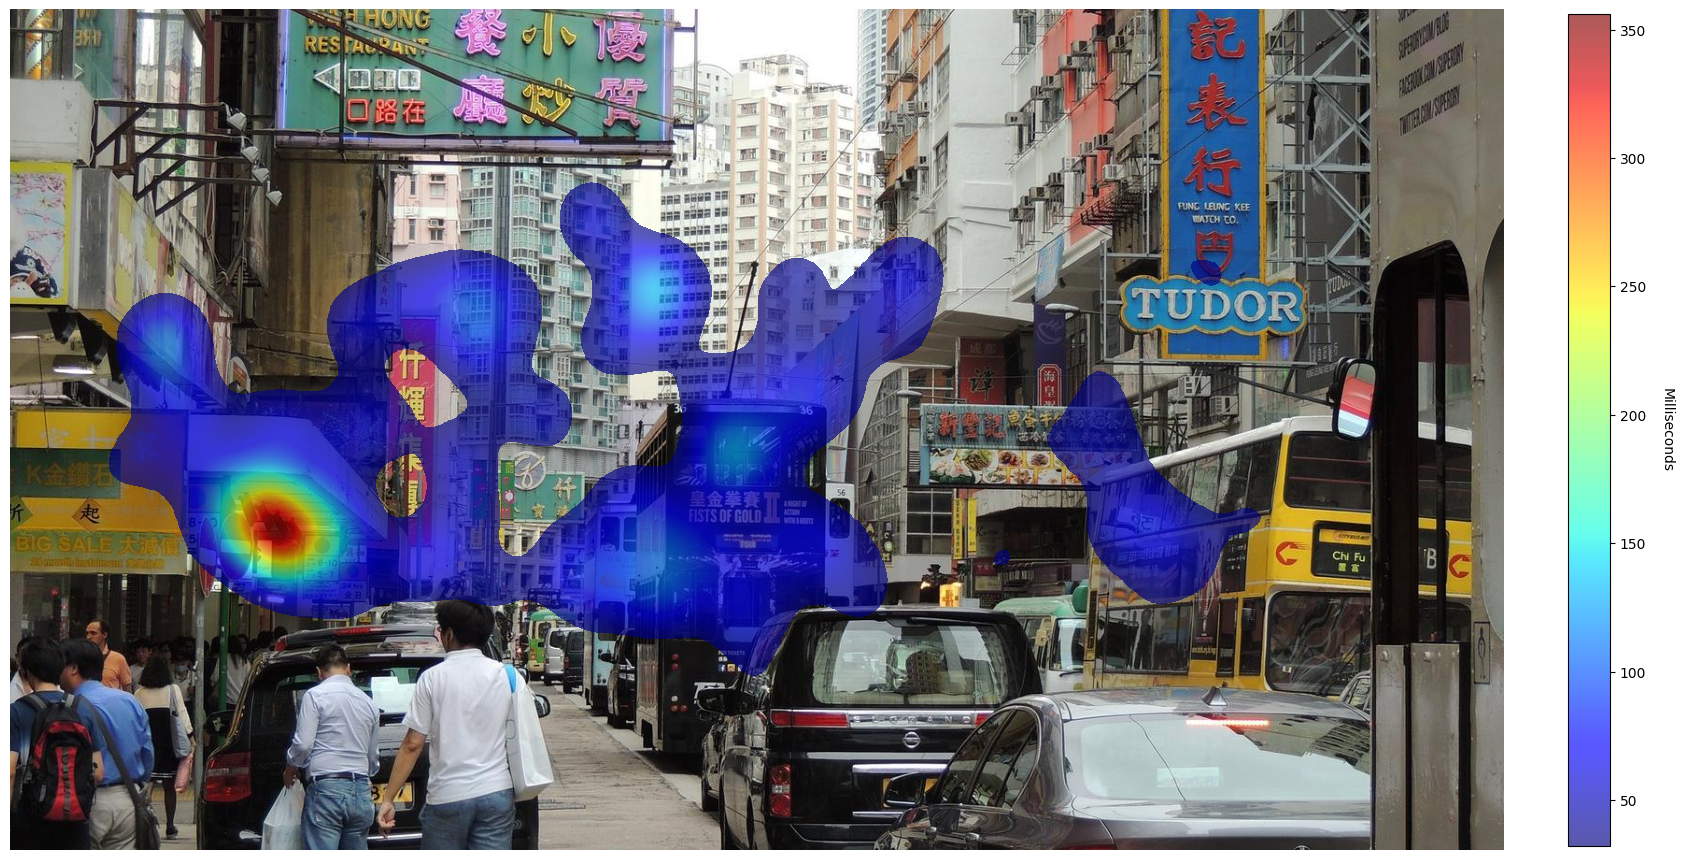

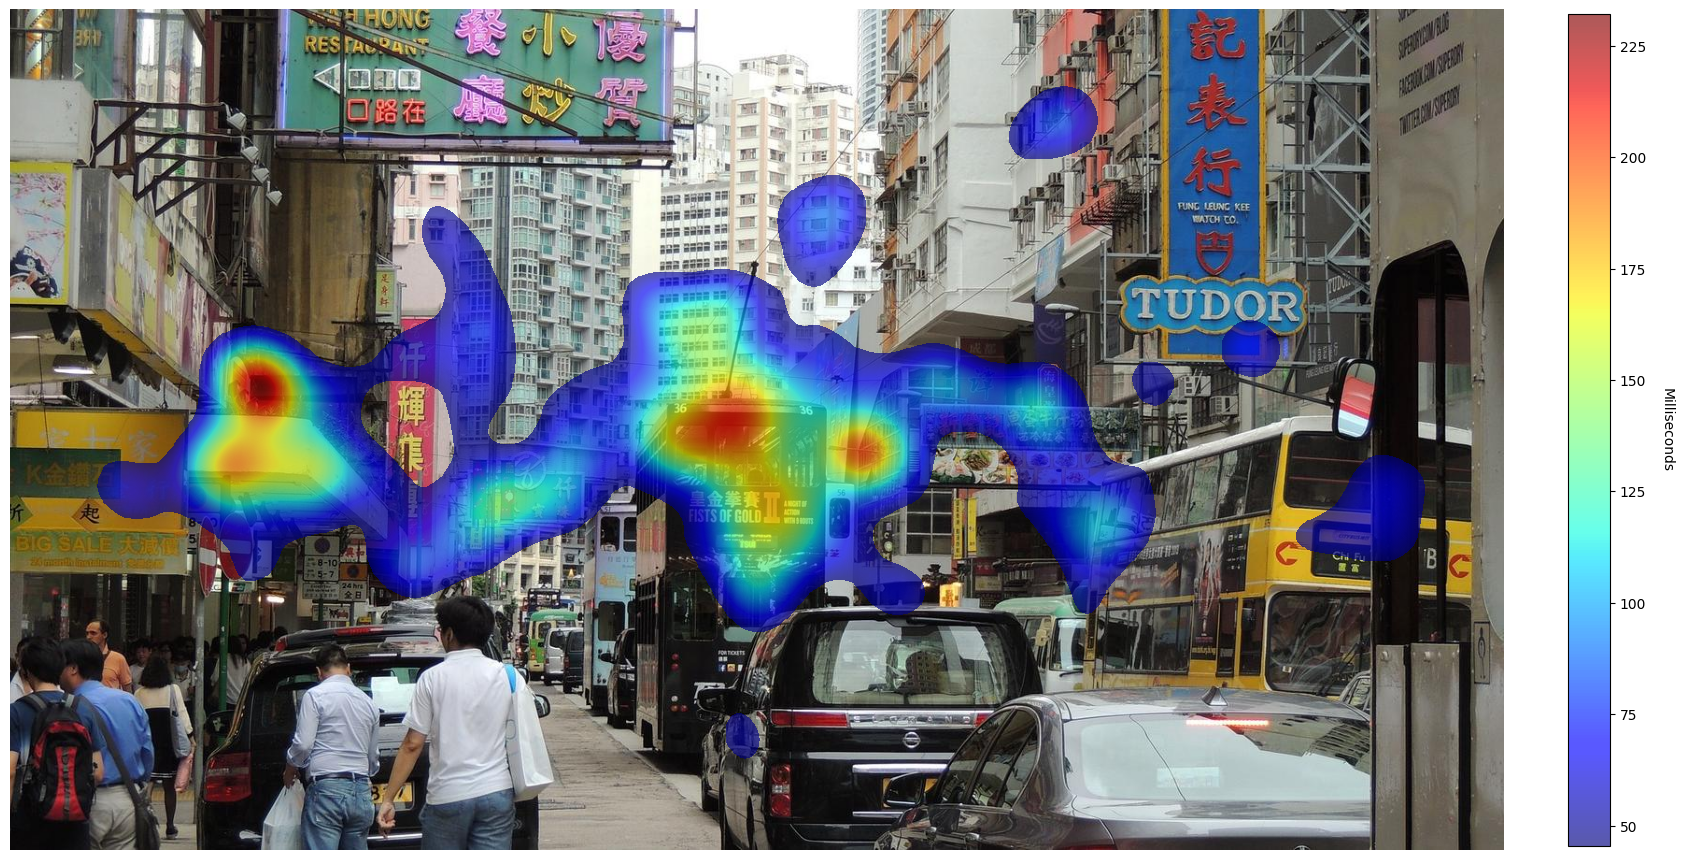

In [42]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import cv2

class GazeHeatmap:
    def __init__(self, participants, image_name, window_size, display_width=1600, display_height=900, alpha=0.6, n_gaussian_matrix=100, standard_deviation=30, gaussian_threshold=0.8):
        self.root_dir = '../../../'
        self.participants = participants
        self.image_name = image_name
        self.image_name_clean = image_name.split('.')[0]
        self.window_size = window_size # seconds
        self.window_frames = self.window_size * 60 # 60Hz
        
        self.image_path = os.path.join(self.root_dir, 'Data_Collection/FreeViewing/Training/', self.image_name)
        self.display_width = display_width
        self.display_height = display_height
        self.alpha = alpha
        self.n_gaussian_matrix = n_gaussian_matrix
        self.standard_deviation = standard_deviation
        self.gaussian_threshold = gaussian_threshold
        
        self.output_filedir = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Heatmap')
        if not os.path.exists(self.output_filedir):
            os.makedirs(self.output_filedir)
        self.output_filepath = os.path.join(self.output_filedir, f'combined_{self.image_name_clean}_{self.window_size}sec.jpg')

    def draw_display(self):
        screen = np.zeros((self.display_height, self.display_width, 3), dtype='float32')
        if self.image_path is not None:
            if not os.path.isfile(self.image_path):
                raise Exception(f"ERROR in draw_display: imagefile not found at '{self.image_path}'")
            # Load image with matplotlib's image module
            img = image.imread(self.image_path)
            # Ensure the image is in the correct format
            if img.dtype == np.float32:
                # Normalize if the image is in float format (common for .png)
                img = np.clip(img, 0, 1)
            elif img.dtype == np.uint8:
                # Convert to float and normalize if the image is in byte format (common for .jpg)
                img = img.astype('float32') / 255

            # width and height of the image
            w, h = img.shape[1], img.shape[0]
            # x and y position of the image on the display
            x = self.display_width // 2 - w // 2
            y = self.display_height // 2 - h // 2
            # draw the image on the screen
            screen[y:y + h, x:x + w, :] += img[:,:,:3]  # Use only RGB channels
        dpi = 100.0
        figsize = (self.display_width / dpi, self.display_height / dpi)
        fig = plt.figure(figsize=figsize, dpi=dpi, frameon=False)
        ax = plt.Axes(fig, [0, 0, 1, 1])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.axis([0, self.display_width, 0, self.display_height])
        ax.imshow(screen)
        return fig, ax

    def gaussian(self, x, sx, y=None, sy=None):
        if y is None:
            y = x
        if sy is None:
            sy = sx
        xo = x // 2
        yo = y // 2
        M = np.zeros([y, x], dtype=float)
        for i in range(x):
            for j in range(y):
                M[j, i] = np.exp(-1.0 * (((float(i) - xo) ** 2 / (2 * sx ** 2)) + ((float(j) - yo) ** 2 / (2 * sy ** 2))))
        return M

    def draw_heatmap(self, gaze_data):
        fig, ax = self.draw_display()
        gwh = self.n_gaussian_matrix
        gsdwh = gwh // 6 if (self.standard_deviation is None) else self.standard_deviation
        gaus = self.gaussian(gwh, gsdwh)
        strt = gwh // 2
        heatmapsize = self.display_height + 2 * strt, self.display_width + 2 * strt
        heatmap = np.zeros(heatmapsize, dtype=float)
        for x, y, weight in gaze_data:
            x = strt + x - gwh // 2
            y = strt + y - gwh // 2
            if 0 > x or x > self.display_width or 0 > y or y > self.display_height:
                continue
            heatmap[y:y + gwh, x:x + gwh] += gaus * weight
        heatmap = heatmap[strt:self.display_height + strt, strt:self.display_width + strt]

        # Apply Gaussian blur to smooth the heatmap
        heatmap = cv2.GaussianBlur(heatmap, (21, 21), 0)

        lowbound = np.percentile(heatmap[heatmap > 0], int(self.gaussian_threshold*100))  # Adjust the percentile as needed
        heatmap[heatmap < lowbound] = np.NaN
        im = ax.imshow(heatmap, cmap='jet', alpha=self.alpha, vmin=lowbound, vmax=np.nanmax(heatmap))
        ax.invert_yaxis()

        # Add colorbar legend
        cbar = plt.colorbar(im, ax=ax, fraction=0.026, pad=0.04)
        cbar.set_label('Milliseconds', rotation=270, labelpad=20)
        
        if self.output_filepath is not None:
            fig.savefig(self.output_filepath)
        return fig

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6/5 * p[0] - 1/10, 6/5 * p[1] - 1/10)

    def to_pixel(self, coord):
        coord = eval(coord)
        if len(coord)!= 2 or coord[0] == None or coord[1] == None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)

    def run(self):
        combined_gaze_data = []
        for participant in self.participants:
            input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{participant}_IMG_1.csv')
            df = pd.read_csv(input_filepath, low_memory=False)
            # Create a condition to filter the DataFrame
            condition = df['stimuli'] == self.image_name_clean
            selected_data = df[condition].iloc[-self.window_frames:]


            if selected_data.empty:
                raise ValueError(f"No data found for the given window size: {self.window_size} seconds for participant {participant}")
            
            gaze_cor_name = "{}_gaze_point_on_display_area".format(df.loc[condition, 'eye_to_use'].iloc[0])
            
            selected_data['pixel_gaze_point'] = selected_data[gaze_cor_name].apply(self.to_pixel)
            gaze_data_list = selected_data['pixel_gaze_point'].tolist()
            # Filter out (None, None) entries
            filtered_gaze_data_list = [cor for cor in gaze_data_list if cor != (None, None)]
            combined_gaze_data.extend([(int(cor[0]), int(cor[1]), 1) for cor in filtered_gaze_data_list])
        
        self.draw_heatmap(combined_gaze_data)

# split the participants by MW and run the heatmap for each group
def split_participants_by_MW(image_name, blacklist=None):
    MW_list = []
    Focus_list = []
    input_filedir = '../../../Preprocess/FreeViewing/Data'
    for file_name in os.listdir(input_filedir):
        if file_name.startswith('.'): continue
        participant = file_name.split('_')[0]
        if participant in blacklist: continue
       
        input_filepath = os.path.join(input_filedir, file_name)
        df = pd.read_csv(input_filepath, low_memory=False)
        image_name_clean = image_name.split('.')[0]
        condition = df['stimuli'] == image_name_clean
        MW_state = 0
        if df[condition].iloc[-1]['state'] == 'num_6': MW_state = 1
        if MW_state: MW_list.append(participant)
        else: Focus_list.append(participant)
        
    return sorted(MW_list), sorted(Focus_list)
    
    
if __name__ == '__main__':
    blacklist = ["22K", "25I", "29N", "39Y"]
    image_name = 'HongKong_3.jpg'
    window_size = 6 # seconds
    
    n_gaussian_matrix = 150
    standard_deviation = 30
    alpha = 0.65
    gaussian_threshold = 0.8
    
    MW_list, Focus_list = split_participants_by_MW(image_name, blacklist)
    
    print(f"MW_list: {MW_list}")
    print(f"Now running heatmap for MW participants")
    heatmap = GazeHeatmap(MW_list, image_name, window_size, n_gaussian_matrix=n_gaussian_matrix, standard_deviation=standard_deviation, alpha=alpha, gaussian_threshold=gaussian_threshold)
    heatmap.run()
    
    print(f"Focus_list: {Focus_list}")
    print(f"Now running heatmap for Focus participants")
    heatmap = GazeHeatmap(Focus_list, image_name, window_size, n_gaussian_matrix=n_gaussian_matrix, standard_deviation=standard_deviation, alpha=alpha, gaussian_threshold=gaussian_threshold)
    heatmap.run()

Processing India_3...
No data found for MW state 0 for India_3
Processing NYC_1...
No data found for MW state 1 for NYC_1
Processing London_1...
No data found for MW state 1 for London_1
Processing Brazil_3...
No data found for MW state 0 for Brazil_3
Processing India_1...
No data found for MW state 0 for India_1
Processing Mexico_3...
No data found for MW state 0 for Mexico_3
Processing Italy_1...
No data found for MW state 0 for Italy_1
Processing NYC_4...
No data found for MW state 0 for NYC_4
Processing HongKong_1...
No data found for MW state 0 for HongKong_1
Processing Singapore_1...
No data found for MW state 1 for Singapore_1
Processing Vietnam_1...
No data found for MW state 1 for Vietnam_1
Processing Sweden_2...
No data found for MW state 0 for Sweden_2
Processing France_1...
No data found for MW state 0 for France_1
Processing Italy_4...
No data found for MW state 0 for Italy_4
Processing Mexico_1...
No data found for MW state 0 for Mexico_1
Processing HongKong_3...
No data 

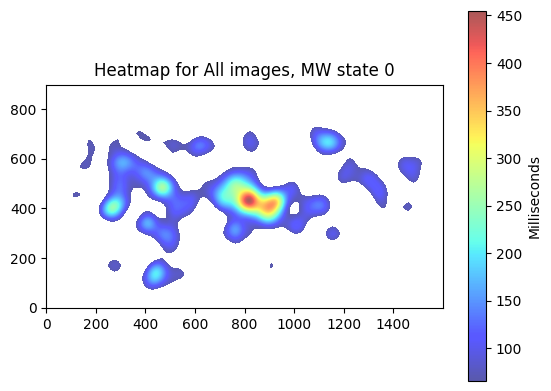

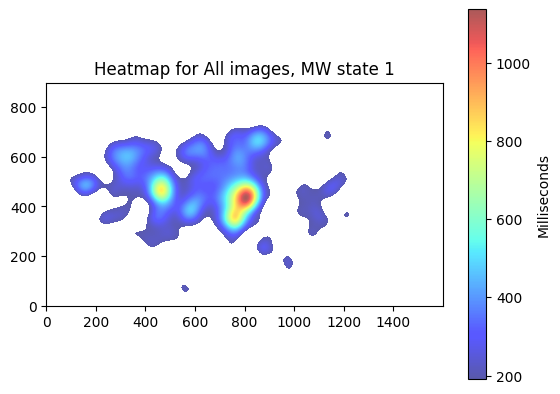

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

class GazeHeatmap:
    def __init__(self, participant, window_size, display_width=1600, display_height=900, alpha=0.6, n_gaussian_matrix=100, standard_deviation=30, gaussian_threshold=0.8):
        self.root_dir = '../../../'
        self.participant = participant
        self.window_size = window_size # seconds
        self.window_frames = self.window_size * 60 # 60Hz
        self.display_width = display_width
        self.display_height = display_height
        self.alpha = alpha
        self.n_gaussian_matrix = n_gaussian_matrix
        self.standard_deviation = standard_deviation
        self.gaussian_threshold = gaussian_threshold
        
        self.input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{self.participant}_IMG_1.csv')
        self.output_filedir = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Heatmap')
        if not os.path.exists(self.output_filedir):
            os.makedirs(self.output_filedir)

    def gaussian(self, x, sx, y=None, sy=None):
        if y is None:
            y = x
        if sy is None:
            sy = sx
        xo = x // 2
        yo = y // 2
        M = np.zeros([y, x], dtype=float)
        for i in range(x):
            for j in range(y):
                M[j, i] = np.exp(-1.0 * (((float(i) - xo) ** 2 / (2 * sx ** 2)) + ((float(j) - yo) ** 2 / (2 * sy ** 2))))
        return M

    def draw_heatmap(self, gaze_data, title):
        if not gaze_data:
            print(f"No valid gaze data for {title}. Skipping heatmap generation.")
            return

        gwh = self.n_gaussian_matrix
        gsdwh = gwh // 6 if (self.standard_deviation is None) else self.standard_deviation
        gaus = self.gaussian(gwh, gsdwh)
        strt = gwh // 2
        heatmapsize = self.display_height + 2 * strt, self.display_width + 2 * strt
        heatmap = np.zeros(heatmapsize, dtype=float)
        for x, y, _ in gaze_data:
            x = strt + x - gwh // 2
            y = strt + y - gwh // 2
            if 0 > x or x > self.display_width or 0 > y or y > self.display_height:
                continue
            heatmap[y:y + gwh, x:x + gwh] += gaus
        heatmap = heatmap[strt:self.display_height + strt, strt:self.display_width + strt]

        # Apply Gaussian blur to smooth the heatmap
        heatmap = cv2.GaussianBlur(heatmap, (21, 21), 0)

        if np.all(heatmap == 0):
            print(f"Heatmap for {title} has no data after Gaussian blur. Skipping visualization.")
            return

        lowbound = np.percentile(heatmap[heatmap > 0], int(self.gaussian_threshold * 100))  # Adjust the percentile as needed
        heatmap[heatmap < lowbound] = np.NaN
        
        plt.imshow(heatmap, cmap='jet', alpha=self.alpha, vmin=lowbound, vmax=np.nanmax(heatmap))
        plt.colorbar(label='Milliseconds')
        plt.title(f"Heatmap for {title}")
        plt.gca().invert_yaxis()
        plt.show()

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6 / 5 * p[0] - 1 / 10, 6 / 5 * p[1] - 1 / 10)

    def to_pixel(self, coord):
        coord = eval(coord)
        if len(coord) != 2 or coord[0] is None or coord[1] is None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)

    def run(self):
        df = pd.read_csv(self.input_filepath)

        # Create 'MW' column based on 'state'
        df['MW'] = df['state'].apply(lambda x: 1 if x == 'num_6' else 0)
        
        mw_gaze_data = {0: [], 1: []}

        stimuli_names = df['stimuli'].dropna().unique()

        for image_name_clean in stimuli_names:
            print(f"Processing {image_name_clean}...")
            condition = df['stimuli'] == image_name_clean
            selected_data = df[condition].iloc[-self.window_frames:]

            if selected_data.empty:
                print(f"No data found for the given window size: {self.window_size} seconds for {image_name_clean}")
                continue

            for mw_state in [0, 1]:
                mw_condition = selected_data['MW'] == mw_state
                mw_data = selected_data[mw_condition]

                if mw_data.empty:
                    print(f"No data found for MW state {mw_state} for {image_name_clean}")
                    continue

                gaze_cor_name = "{}_gaze_point_on_display_area".format(df.loc[condition, 'eye_to_use'].iloc[0])
                mw_data['pixel_gaze_point'] = mw_data[gaze_cor_name].apply(self.to_pixel)
                gaze_data_list = mw_data['pixel_gaze_point'].tolist()
                filtered_gaze_data_list = [cor for cor in gaze_data_list if cor != (None, None)]
                mw_gaze_data[mw_state].extend([(int(cor[0]), int(cor[1]), 1) for cor in filtered_gaze_data_list])

        for mw_state in [0, 1]:
            self.draw_heatmap(mw_gaze_data[mw_state], f"All images, MW state {mw_state}")

if __name__ == '__main__':
    participant = '1Y'
    window_size = 30 # seconds

    n_gaussian_matrix = 150
    standard_deviation = 30
    alpha = 0.65
    gaussian_threshold = 0.8

    heatmap = GazeHeatmap(participant, window_size, n_gaussian_matrix=n_gaussian_matrix, standard_deviation=standard_deviation, alpha=alpha, gaussian_threshold=gaussian_threshold)
    heatmap.run()
